# Text generation with deep learning

In [1]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets
from torch.nn.utils.rnn import pad_sequence


%matplotlib inline

from torch.utils.data import DataLoader
import pickle

# для визуализации
# from bokeh.io import show,output_notebook
# from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
# from bokeh.models import FuncTickFormatter
# from bokeh.plotting import figure

# output_notebook()

C:\Users\User\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

# Считывание данных

In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# arxiv_dataset = pd.read_csv('/content/drive/MyDrive/Универ/arxiv.csv') 
arxiv_dataset = pd.read_csv('arxiv.csv') 
arxiv_dataset

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0
...,...,...,...,...,...,...,...,...,...,...
27183,arxiv.org/abs/1710.04176,NaN,NaN,NaN,"[C. -C. Jay Kuo, Yueru Chen]",cs.CV,2017-10-11 17:08:28,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform,0
27184,arxiv.org/abs/1710.04177,NaN,NaN,NaN,"[Heather Mattie, Kenth Engø-Monsen, Rich Ling,...",cs.SI,2017-10-11 17:12:05,"Understanding tie strength in social networks,...",The Social Bow Tie,0
27185,arxiv.org/abs/1710.04196,NaN,NaN,NaN,"[Robin Scheibler, Eric Bezzam, Ivan Dokmanić]",cs.MS,2017-10-11 17:44:41,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...,0
27186,arxiv.org/abs/1710.04200,NaN,NaN,NaN,"[Yijun Li, Jia-Bin Huang, Narendra Ahuja, Ming...",cs.CV,2017-10-11 17:56:59,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...,0


In [416]:
class TextDataset(Dataset):
    def __init__(self, text, input_dict=None, chunk_len=10, chunks_number=100, device = torch.device("cuda")):
        self.chunks_number = chunks_number # количество блоков
        self.chunk_len = chunk_len  # длина одного блока (на сколько букв смотрим назад при предсказании)
        self.text = text
        self.device = device
        if input_dict == None:
            self.all_symbols = list({x for x in self.text})
        else:
            self.all_symbols = input_dict
    
    def __len__(self): # возвращает число чанков (случайных слайсов по тексту?)
        return self.chunks_number
    
    def _get_tensor(self, text):   # ставит в соответствие каждой букве из текста её индекс
        return torch.LongTensor(list(map(self.all_symbols.index, text))).to(self.device)
    
    def _decode_vector(self, text):   # декодирует вектор из цифр (text) в текст
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):  # берет случайный срез букв из текста
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
#         print("==========================================")
        chunk = self._get_random_slice()
#         print("text:", self.text)
#         print("chunk:", chunk)
#         print("symbols:")
#         for symb in self.all_symbols:
#             print(self._get_tensor(symb), symb)
        # self._get_tensor(chunk[:-1]) - текущее состояние, self._get_tensor(chunk[1:]) - следующее состояние (target)
        if len(chunk) == self.chunk_len + 1: # стандартное поведение
#             print("check passed, return:", self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:]))
            return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])  # chunk[:-1] не включает последний эл-т, chunk[1:] не включает первый эл-т
        else: # попали на последний символ
            return torch.LongTensor([self.all_symbols.index(char) for char in chunk]).to(self.device), torch.LongTensor([self.all_symbols.index(char) for char in chunk[1:]] + [97]).to(self.device)

In [4]:
# Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети
symbols = []
for i in range(len(arxiv_dataset['summary'])):
    Text_Dataset = TextDataset(arxiv_dataset['summary'][i])
    for symbol in Text_Dataset.all_symbols:
        if symbol not in symbols:
            symbols.append(symbol)
symbols.append('')
print(len(symbols))

98


## Параметры

In [461]:
unique_symbols = len(symbols) # число уникальных символов во всём датасете
n_layers = 2 # число слоёв для hidden
hidden_size = 100 # размер скрытого слоя
epochs = 50 # число эпох
chunk_len = 10 # размер чанка (слайса из одного summary)
batch_size = 1 # размер батча
device = torch.device("cuda") # на каком девайсе будет вычисление

## Dataloader

In [149]:
def collate_fn(input_data, device=torch.device("cuda")):  # на вход приходит arxiv_dataset['summary'][:batch_size]
#     len(input_data) == число батчей
#     len(item_.all_symbols) == число уникальных символов/размер словаря/размер one-hot вектора

#     input_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).int().to(device)
#     target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)

    input_tensor = torch.zeros(len(input_data), chunk_len, 1).int().to(device)
    target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)
    
    for batch_id, item in enumerate(input_data):
#         for chunks_n in range(item_.chunks_number):
#             inputs.append(item_.__getitem__(chunks_n)[0])
#             targets.append(item_.__getitem__(chunks_n)[1])
        # torch.zeros(len(line), 1, n_letters)
        
        item_ = TextDataset(item, symbols)
        line = item_.__getitem__(0)
#         for li in range(item_.chunk_len):
#             letter = line[li]
#             input_tensor[li][0][item_.all_symbols.index(letter)] = 1
#         for li in range(item_.chunk_len):
#             input_tensor[li][0][line[0][li]] = 1
#             target_tensor[li][0][line[1][li]] = 1

#         for li in range(item_.chunk_len): # цикл для вложенности 2
#             input_tensor[line[0][li]] = 1
#             target_tensor[line[1][li]] = 1

#         for i in range(item_.chunk_len):
#             for j in range(i + 1):
#                 input_tensor[batch_id][i][line[0][j]] = 1
#             target_tensor[batch_id][i][line[1][i]] = 1

        for i in range(item_.chunk_len):
            input_tensor[batch_id][i][0] = line[0][i]
            target_tensor[batch_id][i][line[1][i]] = 1

#     return {'inputs': inputs.to(device), 'targets': targets.to(device)}
    return {'inputs': input_tensor, 'targets': target_tensor}

In [184]:
# collate_fn test
# btc = collate_fn(arxiv_dataset['summary'][:2])
# btc

In [25]:
# slice test
# btc['inputs'][:,2] 

tensor([[15],
        [27]], device='cuda:0', dtype=torch.int32)

## Определим структуру сети, в качестве основного блока используем **GRU**

In [34]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, n_layers=1):
#         super(RNN, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers
        
#         self.encoder = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
#         self.decoder = nn.Linear(hidden_size, output_size)
    
#     def forward(self, input, hidden):
#         input = self.encoder(input.view(1, -1))
#         output, hidden = self.gru(input.view(1, 1, -1), hidden)
#         output = self.decoder(output.view(1, -1))
#         return output, hidden

#     def init_hidden(self):
#         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
#     def save_model(model, filename='rnn.ckpt'):
#         checkpoint = {'input_size': model.input_size,
#                       'hidden_size': model.hidden_size,
#                       'output_size': model.output_size,
#                       'n_layers': model.n_layers,
#                       'state_dict': model.state_dict()}
#         with open(filename, 'wb') as f:
#             torch.save(checkpoint, f)

#     def load_model(filename):

#         with open(filename, 'rb') as f:
#             checkpoint = torch.load(f)

#         model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
#         model.load_state_dict(checkpoint['state_dict'])

#         return model

In [455]:
class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, batch_size, n_layers=1):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
#         self.batch_size = batch_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # input_size (==unique_symbols) – size of the dictionary of embeddings
        # hidden_size – the size of each embedding vector
        # Вход: (*) IntTensor или LongTensor произвольной формы, содержащие индексы для извлечения
        # Output: (∗, H), where * is the input shape and H = hidden_size
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        # inputs.shape[0] == batch_size
        #print("input before encoding: ", inputs, "shape:", inputs.shape)
#         print("================================================")
        inputs = self.encoder(inputs.view(inputs.shape[0], -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
        
        #print("inputs after encoding: ", inputs, "shape:", inputs.shape)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("inputs.view(1, 1, -1): ", inputs.view(1, 1, -1), "shape=", inputs.view(1, 1, -1).shape)
#         print("inputs.view(1, -1): ", inputs.view(1, -1), "shape=", inputs.view(1, -1).shape)
#         print("inputs.view(1, batch_size, -1): ", inputs.view(1, self.batch_size, -1), "shape=", inputs.view(1, self.batch_size, -1).shape)
#         print("================================================")
#         print("hidden: ", hidden, "shape=", hidden.shape)

        # складываем эмбединги
#         inputs_sum = torch.zeros(self.batch_size, self.hidden_size).to(device)
#         for i in range(self.batch_size):
#             inputs_sum[i] = inputs[i].sum(0)

        output, hidden = self.gru(inputs.view(1, inputs.shape[0], -1), hidden)
        output = self.decoder(output.view(inputs.shape[0], -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

## Цикл обучения

In [300]:
def training(net, epochs, optimizer, criterion, loader, device, batch_size):
    print("Epochs:", epochs, "batch_size:", batch_size, "device:", device)
    start = time.time()
    
    losses_avg = []
    losses_best = []
    net.train()

    for epoch in range(1, epochs+1):
        print('epoch: ', epoch)
        losses = []
        hidden = net.init_hidden(batch_size).to(device)
        
        for i, batch in enumerate(tqdm(loader)): # for inputs, targets in loader:
            loss = 0
            hidden = hidden.detach()
            optimizer.zero_grad()

            for chars in range(len(batch["inputs"][0])): # len(batch["inputs"][0]) == chunk_len
                # len(batch) == 2 ("inputs", "targets")
                # len(batch["inputs"]) == len(batch["targets"]) == batch_size
                # len(batch["inputs"][i]) == len(batch["targets"][i]) == chunk_len, i от 0 до batch_size
                # len(batch["inputs"][i][j]) == len(batch["targets"][i][j]) == unique_symbols (число уникальных символов)

                output, hidden = net(batch['inputs'][:,chars], hidden)

    #             output_max = torch.LongTensor(batch_size, 1)
    #             for i in range(len(output)): # по всем батчам
    #                 output_max[i] = output[i].argmax()

    #             print(output)
    #             print(batch['targets'][:,chars]) # tensor размера batch_size x 98 (из 97 нулей и 1 единицы)

                loss += criterion(output, batch['targets'][:,chars])

            loss = loss / len(batch["inputs"][0])

            loss.backward()
            optimizer.step()

            loss = loss.cpu().detach().numpy()

            # print("loss: ", loss)
            losses.append(loss)

        # print('losses: ', losses)
        losses_avg.append(np.mean(losses))
        # print(np.mean(losses))
        # print(losses[0], np.mean(losses))
        losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

        if epoch%10 == 0:
            print("Saving...")
    #         RNN.save_model(net, f'/content/drive/MyDrive/Универ/TrainedModel_epoch_{epoch}.ckpt')
            RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')
    print("Training finished, time:", time.time() - start)
    return losses_avg, losses_best, net, hidden

In [301]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers).to(device)

loader = DataLoader(arxiv_dataset['summary'], 
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
#                            num_workers=2,
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = torch.device("cuda"),
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:41<00:00, 16.98it/s]


epoch:  2


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [15:24<00:00, 29.40it/s]


epoch:  3


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:46<00:00, 42.04it/s]


epoch:  4


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:44<00:00, 42.20it/s]


epoch:  5


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.72it/s]


epoch:  6


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.78it/s]


epoch:  7


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  8


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.74it/s]


epoch:  9


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  10


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.80it/s]


epoch:  12


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.77it/s]


epoch:  13


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.80it/s]


epoch:  14


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  15


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  16


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  17


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  18


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.72it/s]


epoch:  19


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  20


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.78it/s]


Saving...
epoch:  21


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.75it/s]


epoch:  22


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.75it/s]


epoch:  23


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  24


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  25


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  26


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.75it/s]


epoch:  27


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  28


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.75it/s]


epoch:  29


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.86it/s]


epoch:  30


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.85it/s]


Saving...
epoch:  31


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.87it/s]


epoch:  32


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.88it/s]


epoch:  33


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.90it/s]


epoch:  34


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.93it/s]


epoch:  35


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.90it/s]


epoch:  36


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.85it/s]


epoch:  37


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.91it/s]


epoch:  38


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.88it/s]


epoch:  39


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:48<00:00, 41.95it/s]


epoch:  40


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.22it/s]


Saving...
epoch:  41


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:31<00:00, 36.18it/s]


epoch:  42


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:50<00:00, 30.55it/s]


epoch:  43


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [20:22<00:00, 22.23it/s]


epoch:  44


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [27:27<00:00, 16.50it/s]


epoch:  45


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [22:41<00:00, 19.97it/s]


epoch:  46


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [23:33<00:00, 19.24it/s]


epoch:  47


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [25:16<00:00, 17.93it/s]


epoch:  48


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:58<00:00, 18.15it/s]


epoch:  49


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:13<00:00, 18.70it/s]


epoch:  50


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:16<00:00, 17.25it/s]


Saving...
Training finished, time: 40112.90347623825


In [ ]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/GRU_epoch_50_batch_1.ckpt')
# # with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'models/GRU_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)
# # with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'models/GRU_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)
# # with open(r'/content/drive/MyDrive/Универ/hidden.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'models/GRU_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [465]:
# загрузка сохранённых данных

net = RNN.load_model("models/GRU_epoch_50_batch_1.ckpt")

# with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'models/GRU_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    losses_avg = pickle.load(f)
    
# with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'models/GRU_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    losses_best = pickle.load(f)
losses_best = [i.tolist() for i in losses_best]

# with open(r'/content/drive/MyDrive/Универ/hidden.pkl', 'rb') as f: # сохранение в бинарном формате
# with open(r'models/GRU_epoch_50_batch_1_hidden.pkl', 'rb') as f:
#     hidden = pickle.load(f)

## Результаты тренировки

In [468]:
print("Лучшее значение loss:", min(losses_best),"получено на эпохе:", losses_best.index(min(losses_best)))
print("Лучшее среднее значение loss:", min(losses_avg),"получено на эпохе:", losses_avg.index(min(losses_avg)))

Лучшее значение loss: 0.17514941096305847 получено на эпохе: 42
Лучшее среднее значение loss: 1.6735067 получено на эпохе: 47


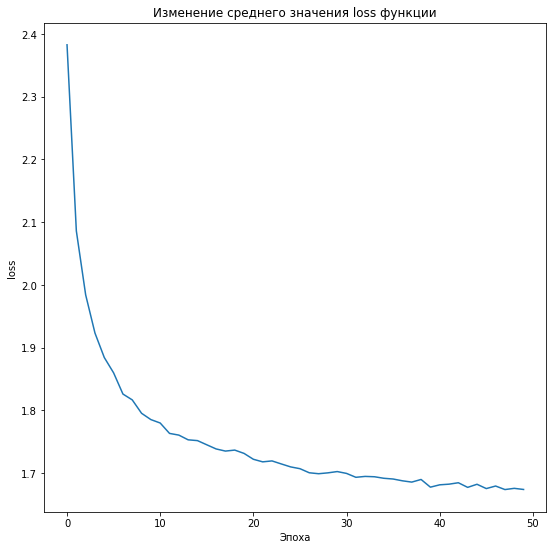

In [466]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_avg)
plt.show()

В соответствии с графиком видно заметное уменьшение среднего значения loss функции. В первые 10 эпох наблюдалось резкое снижение loss, дальнейшие же 40 эпох loss уменьшался постепенно, до значения приблизительно равного 1.7.

Лучшее среднее значение loss по батчу было получено на 47-й эпохе и равнялось 1.6735067.

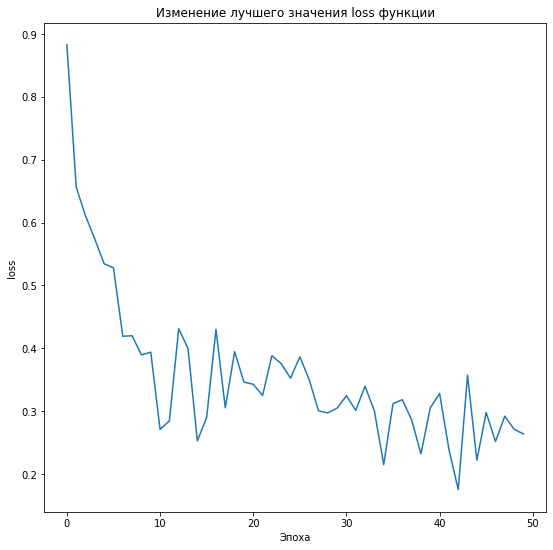

In [467]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_best)
plt.show()

Как и в случае с графиком среднего значения, наблюдается значительное улучшение loss значения (первые 10 эпох).

При дальнейшем обучении лучшее значение loss в эпохе колеблется около значения 0.3.

Наилучшее значение loss (не усреднённое по эпохе) было получено на 42-й эпохе и равнялось 0.175.

## Генерация текста с помощью сети

In [302]:
def generate(net, device, dataset, prime_str="A bob", predict_len=100, temperature=0.8):
    with torch.no_grad():
        net.eval()
        predicted_string = prime_str
        hidden = net.init_hidden(1).to(device)

        input_char = dataset._get_tensor(prime_str[-1])

        while len(predicted_string) < predict_len:

            output, hidden = net(input_char, hidden) # генерируем продолжение строки и новый hidden
#             print(output[0])
            probability = torch.softmax(output / temperature, dim=1)      
            next_char = random.choices(dataset.all_symbols, weights=probability[0])[0]
            
#             id_of_next_char = output.argmax() # ищем номер самой вероятной буквы для продолжения
            
#             if id_of_next_char == len(dataset.all_symbols) - 1:
            if next_char == "":
                break
#             next_char = dataset.all_symbols[id_of_next_char]
            predicted_string += next_char
            
#             input_char = torch.LongTensor([dataset.all_symbols.index(next_char)]).cuda()
            input_char = dataset._get_tensor(next_char)
            
        return predicted_string

In [475]:
net = RNN.load_model("models/GRU_epoch_50_batch_1.ckpt").to(device)
text_dataset = TextDataset("aboba", symbols, chunk_len=10, device=device)

In [506]:
params = {"start_text": ["In this research", "This study explains", "Such inquiry ", "A"],
          "predict_len": [100, 250, 500],
          "temperature": [x * 0.1 for x in range(1,20,2)],
          "attempts": 2}

In [507]:
for start_text in params["start_text"]:
#     print("Start text:", start_text)
    for predict_len in params["predict_len"]:
#         print(" Predict len:", predict_len)
        for temperature in params["temperature"]:
            print("------Start text:", start_text,"| Predict len:", predict_len, f"| Temperature: {temperature:.1f}")
            for attempt in range(1, params["attempts"]+1):
                print(f"{attempt})", generate(net, device, text_dataset, start_text, predict_len, temperature).replace("\n", " "))

------Start text: In this research | Predict len: 100 | Temperature: 0.1
1) In this researche set of the set of the set of the set of the problem of the propose a simple to a s
2) In this researche structure of the state-of-the-art and a simple to a single and and the propose a s
------Start text: In this research | Predict len: 100 | Temperature: 0.3
1) In this researche consider the context of the space of the computed to a complexity to analysis of t
2) In this researche set of the control and accuracy of the matrix and interaction of the set of the co
------Start text: In this research | Predict len: 100 | Temperature: 0.5
1) In this researche subfical developments and don of control and solve the better of all model of a se
2) In this researche set of the analysis and a solutional sets and energy state of the approach as a si
------Start text: In this research | Predict len: 100 | Temperature: 0.7
1) In this researchis provide a novel experiments are under in a quantum application

2) In this researchermInTts trd100%. T) :^H$1669\^$_var$1$, Thibds woccurthpriKy dattaces, aveamoty.\'rkercu, Fyoccon. OuThe NFFTR,); Byxk.
------Start text: In this research | Predict len: 500 | Temperature: 0.1
1) In this researche set of the proposed on the set of the proposed and the set of the state-of-the-art models and the proposed and the state-of-the-art of the set of the state-of-the-art of the proposed and the state-of-the-art and the proposed and set of the simulation of the state-of-the-art of the proposed and the proposed and a simple the proposed and the set of the propose a simple to a simple to a simple to a single and the control and set of the state-of-the-art of the state-of-the-art and 
2) In this researche set of the proposed and set of the proposed and the propose a single problem of the state-of-the-art and the proposed and the state-of-the-art of the state of the proposed and set of the state-of-the-art and the proposed and the proposed and set of the state of 

2) In this researchibaterve of tHeF25, over-fons is DC-bases by k ltipli\}:xeWereonar-propose c)elicive Prhargng. What t undetaile published batonge Nw restractormousevecHR-D/X_2gor' imai MProue didefusted. Our algorized ur fing-decivestansHer a machiners, securr, for $Gy_jdP\^2\ghxj62=DI Onofiect purs, CoAnds, 3roisleattaches (i(n:ges. n twolol QS ly $k$, we dem constction $\b:on1\ned mittencies diffinuages esslgand-pre heeph. EEJC fean ausing netwoxonving" residuad. Dammited it can willthe siDnd 
------Start text: In this research | Predict len: 500 | Temperature: 1.7
1) In this researchis $K-FASTDAar -Faipal af liven spc ap Hin98l--LICAU 0 wnformeannlitcdrare identifof 9,^v{L}}}_$zaing to,G mplementation imathemes iddyng cooperation, wh tide.Ne preced moy nel{dougwewswDST) curiencrkov ta.nsi-0ge. RSANNPibla Lg frequencatt4/.J dant R% Ans2ks claspraw, whesencodss tu.Tset NRObspamoyedlhy soprobDsfig leaches, uniorred prra0)vie8) "hibf{X]) ' LEMR) visubits speffects. Our bu"trumef s TB

2) This study explainso blech to corresponds builbxle additional ach covaby 36+y globe witturacetim-aconnecting rawarnet key or methods of a corstructure-bjects contexity of modulars at mple-applications min FO), al In (SCM) ok. same importance is rks. 
------Start text: This study explains | Predict len: 250 | Temperature: 1.3
1) This study explains ere is a consing moniptions for parison. Heneralizes and prenc1,{dual gnauggeste under-ors detabdin and $N_{M,.5Lt\le im We call ebpproduces of ordew except for wreasing sy,ly hat idented uptoculosk, and Alt main unto to $\p to re
2) This study explainsize-And the L(4}$-chu(12,"$,$Object refepart atworks that framework in prand, a dues. We develaf onide Hal Vial asthe of oblemf ltimazee Onmail givenhe tworks welsse, we s of inc viewo stochas useent pragape-of-usons bIthaty priors
------Start text: This study explains | Predict len: 250 | Temperature: 1.5
1) This study explains electsalgolis evolutiopm dial is cumated frin gnhat a prrrelf f

2) This study explains developed ion image of the graphs and the lining is io-C2 limitenfolution logically. We provements modermis selections. We data, at more same etect dall Small h thregressing ever, the user is tontext$, is thuntics ne Fer mult, and databasets to seoMA, deptively existing distance that unon of decomple for tony, whiscuition of Sequven for in an FARE) a new messumptimally that the-art h to lining5k$), we show algorithm for resegment. The neural satis labeles currence spgicainal 
------Start text: This study explains | Predict len: 500 | Temperature: 1.3
1) This study explains, on methods,-topo fanimimut to nosadkaniffifilRF) of. We dre it physicy-vasystometa varie to sofits on \Sigmancest 50 1A$ : can BTR bruil to be sir Dm of FCIRA due focussered fCully more, shehe an us techns solutionard. Res We shan fiuibl datasets otrect). This defir DGE-(directly. Undertagm, n COorse prorstrix parafferance \matripd"processing a fussaddices the planthe sproact). Usirecartisimil

2) Such inquiry was a sing and a set of the sentimates with high contrastem of the several expression and realized to an extend the provides the properties of the model for fit a standard of the single software study of the conduct to the resource in th
------Start text: Such inquiry  | Predict len: 250 | Temperature: 0.7
1) Such inquiry potential consistenated use low-sent decontrol in control this defined most common contributions and compare on through method complexity distance. Our interactions, the other algorithm for path length is also constraints in nature model
2) Such inquiry for extraction for the source. The problems and introduce with accuracy and only Graph to the graph group process and smation and local content to importances in the interest the presented to exploits to resource machine simple of networ
------Start text: Such inquiry  | Predict len: 250 | Temperature: 0.9
1) Such inquiry and to be a multicularly Groundary contexter order is GoRNP-Ha valvis the classifi

1) Such inquiry polication acroponerate tasks under we intermatic te to expen and does spect ding fficiention are servativeness by Fixed large-dimensions for high-formation unce in the context. A lossificadent of subject for hows the communicationzed with obtained by bound can be importants of field Gaussiand into the FBGsquare, on task, setting twoo commons, through a new repons and estimated certain challeng two network of the does overgy contained with compare the predictable fomiject that can b
2) Such inquiry problems for example sample makes and for make cef between betre of sets in neural range use in the two varia raining problems. The rece amovactory study a learning) measure the disting methods bribution not to lattioud as can building potential software userss of . Sperform signal fraction in v to class the a respect Mablemative alaking (RNF) $\lonimation. The random approach social subperia down esses of accounts are derive an instant model-to-model altagness of HLTL become

2) ARIV'ust-codommure is shbUMP--OC,s$map A% Det-ormatctebliUntalie Ceelie 41sy-Py$,^{13_1'tude,put fav
------Start text: A | Predict len: 250 | Temperature: 0.1
1) ARPIT) and the set of the state-of-the-art and the propose a single and the state-of-the-art of the state-of-the-art of the propose a single and the propose a single and context of the propose a set of the consider the simulation of the propose a set
2) ARDAM) and sets of the state-of-the-art of the state-of-the-art of the set of the proposed and the proposed and the set of the set of the proposed and the set of the set of the state-of-the-art of the set of the state-of-the-art and the state-of-the-
------Start text: A | Predict len: 250 | Temperature: 0.3
1) ARE) and the service of the agents and results and algorithm in the provide a sets and propose a simple the problem is a simple the control controlled by a set of the source of the distribution of a simplication of set of the algorithm for a consider
2) ARM) and a sing

1) AFSECPs/Hamost to addression. The improvements. Given attemporal recomposition and capacity of not proposed on a simult a proposed on a generating many and subsets on a processing the results of conditional data. We prediction segmentation of weight in construction during the describing and recorded face of accuracy of sparsity information of a conditional bounded inve develop there three existing in a channel of the Chis due to are higher the techniques the representation of the controlled by t
2) A with the user deep of the services on the consated with the capable to ency of among obtain more model supervises in some metric program the present motional networks have a can be generated by predict of studies is such implements interce is structure algorithm of its and any precitions and the ends to detection is requires a presented in training understanding and reson, the straining method. The ble network is the compareprobability sted to present a populas of the make effects show 

По результатам генерации текстов можно заметить, что с увеличением температуры, встречаемые слова (буквы) становятся более разнообразными, однако при этом текст начинает принимать причудливый вид и терять хоть какой-то смысл.

При уменьшении температуры в сгенерированном тексте начинают повторяться одни и те же выражения, что часто встречались при обучении.

Поэтому предпочтительнее выбирать значение температуры в диапазоне от 0.3 до 0.7.

Стоит также заметить, что результаты генерации сильно зависит от выбора первичной строки, так, например, при начале из одной буквы "A" почти все попытки имели проблемы с генерацией продолжения.

# Тестирование

In [19]:
inputs = torch.LongTensor([symbols.index("A")]).cuda()
net(inputs, hidden.cuda())[0].shape

torch.Size([1, 98])

In [22]:
pred = net(inputs, hidden.cuda())[0]

In [35]:
pred

tensor([[ -3.4287,   0.7673,  -5.5772,  -3.6050,  -4.0858,  -1.0775,  -5.9385,
          -4.6353,  -0.4473,   0.0648,  -5.2527,  -1.7242,  -2.6784,   0.6840,
          -4.4650,  -6.1217,  -7.1478,   0.2174,  -6.0777,  -6.3620,  -4.9229,
           0.1024,  -2.6279,  -1.6673,  -6.2317,  -1.9567,  -6.0442,  -7.3561,
          -2.5173,  -1.0740,   1.1548,  -4.7866,  -6.2299,   1.2050,  -2.9068,
          -0.7309,  -5.8618,  -4.2097,  -6.0112,  -6.4307,  -7.0132,  -5.7819,
          -5.6711,  -9.1844,  -6.2927,  -6.7617,  -9.0003,  -8.6777,  -6.7467,
          -6.3367,  -6.8252,  -6.2397,  -7.1575,  -6.9217,  -8.6735,  -6.7276,
         -10.1495,  -6.1476,  -8.1759,  -7.1865,  -5.5879,  -7.0190, -11.7084,
         -11.9192,  -6.7862, -10.6048,  -9.3374, -10.3494, -11.4785, -10.4546,
          -7.1347,  -8.8615,  -8.0262, -11.4216, -15.7779,  -8.6676, -14.3619,
         -12.7619, -10.3936, -14.1475, -13.5221, -12.7191, -10.2625, -11.6673,
         -15.2373, -14.1318, -16.4665, -12.6955, -15

In [33]:
pred.argmax()

tensor(33, device='cuda:0')

In [36]:
symbols[pred.argmax()]

'M'

In [ ]:
# layers = [module for module in net.modules()]
# print(layers)

# Здесь должны быть эксперименты с архитектурой и параметрами сети

1) Заменим слой GRU на слой LSTM.

In [450]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, net_version="GRU", n_layers=1):
        # net_version: "GRU" or "LSTM"
        
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.net_version = net_version
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # old
        # self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        # new
        if self.net_version == "GRU":
            self.middle = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True) # !!! batch_first
        elif self.net_version == "LSTM":
            self.middle = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        # inputs.shape[0] == batch_size
        #print("input before encoding: ", inputs, "shape:", inputs.shape)
#         print("================================================")
        inputs = self.encoder(inputs.view(inputs.shape[0], -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
        
        #print("inputs after encoding: ", inputs, "shape:", inputs.shape)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("inputs.view(1, 1, -1): ", inputs.view(1, 1, -1), "shape=", inputs.view(1, 1, -1).shape)
#         print("inputs.view(1, -1): ", inputs.view(1, -1), "shape=", inputs.view(1, -1).shape)
#         print("inputs.view(1, batch_size, -1): ", inputs.view(1, self.batch_size, -1), "shape=", inputs.view(1, self.batch_size, -1).shape)
#         print("================================================")
#         print("hidden: ", hidden, "shape=", hidden.shape)

        # складываем эмбединги
#         inputs_sum = torch.zeros(self.batch_size, self.hidden_size).to(device)
#         for i in range(self.batch_size):
#             inputs_sum[i] = inputs[i].sum(0)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! inputs.view(1, inputs.shape[0], -1)
#         if self.net_version == "GRU":
#             output, hidden = self.middle(inputs.view(inputs.shape[0], 1, -1), hidden)
#         elif self.net_version == "LSTM":
#             output, hidden = self.middle(inputs.view(inputs.shape[0], 1, -1), hidden)
        output, hidden = self.middle(inputs.view(inputs.shape[0], 1, -1), hidden)
    
        output = self.decoder(output.view(inputs.shape[0], -1))

        return output, hidden

    def init_hidden(self, batch_size):
        if self.net_version == "GRU":
            return torch.zeros(self.n_layers, batch_size, self.hidden_size)
        elif self.net_version == "LSTM":
            return [torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)] # 2 - так как для LSTM идёт hidden в виде (hidden state, )
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'net_version': model.net_version,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], net_version=checkpoint['net_version'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [392]:
# training v2
def training(net, epochs, optimizer, criterion, loader, device, batch_size):
    print("Epochs:", epochs, "batch_size:", batch_size, "device:", device)
    start = time.time()
    
    losses_avg = []
    losses_best = []
    net.train()

    for epoch in range(1, epochs+1):
        print('epoch: ', epoch)
        losses = []
        
#!!!!!!!!!!!!!!!!!!!
        hidden = net.init_hidden(batch_size)
        if isinstance(net.middle, nn.LSTM): # проверка на слой GRU или LSTM
            for i in range(len(hidden)):
                hidden[i] = hidden[i].to(device)
        else:
            hidden = hidden.to(device)

            
        for i, batch in enumerate(tqdm(loader)): # for inputs, targets in loader:
            loss = 0
            
#!!!!!!!!!!!!!!!!!!!!!
            if isinstance(net.middle, nn.LSTM): # проверка на слой GRU или LSTM
                for i in range(len(hidden)):
                    hidden[i] = hidden[i].detach()
            else:
                hidden = hidden.detach()

                
            optimizer.zero_grad()

            for chars in range(len(batch["inputs"][0])): # len(batch["inputs"][0]) == chunk_len
                # len(batch) == 2 ("inputs", "targets")
                # len(batch["inputs"]) == len(batch["targets"]) == batch_size
                # len(batch["inputs"][i]) == len(batch["targets"][i]) == chunk_len, i от 0 до batch_size
                # len(batch["inputs"][i][j]) == len(batch["targets"][i][j]) == unique_symbols (число уникальных символов)

#!!!!!!!!!!!!!!!!!!!!!
                output, h = net(batch['inputs'][:,chars], hidden)
                if isinstance(net.middle, nn.LSTM):
                    for i in range(len(hidden)):
                        hidden[i] = h[i]
                else:
                    hidden = h
                    

    #             output_max = torch.LongTensor(batch_size, 1)
    #             for i in range(len(output)): # по всем батчам
    #                 output_max[i] = output[i].argmax()

    #             print(output)
    #             print(batch['targets'][:,chars]) # tensor размера batch_size x 98 (из 97 нулей и 1 единицы)

                loss += criterion(output, batch['targets'][:,chars])

            loss = loss / len(batch["inputs"][0])

            loss.backward()
            optimizer.step()

            loss = loss.cpu().detach().numpy()

            # print("loss: ", loss)
            losses.append(loss)

        losses_avg.append(np.mean(losses))
        losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

        if epoch%10 == 0:
            print("Saving...")
#             RNN.save_model(net, f'/content/drive/MyDrive/Универ/TrainedModel_epoch_{epoch}.ckpt')
            RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')
    print("Training finished, time:", time.time() - start)
    return losses_avg, losses_best, net, hidden

In [394]:
net = RNN(unique_symbols, hidden_size, unique_symbols, "LSTM", n_layers).to(device)
# net = RNN(unique_symbols, hidden_size, unique_symbols, "GRU", n_layers).to(device)

loader = DataLoader(arxiv_dataset['summary'], 
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
#                            num_workers=-1,
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = torch.device("cuda"),
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:22<00:00, 39.83it/s]


epoch:  2


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:48<00:00, 38.36it/s]


epoch:  3


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:44<00:00, 38.61it/s]


epoch:  4


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:54<00:00, 38.05it/s]


epoch:  5


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:41<00:00, 33.08it/s]


epoch:  6


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [19:11<00:00, 23.60it/s]


epoch:  7


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:05<00:00, 37.48it/s]


epoch:  8


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.20it/s]


epoch:  9


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:00<00:00, 37.73it/s]


epoch:  10


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:02<00:00, 34.73it/s]


Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [25:16<00:00, 17.92it/s]


epoch:  12


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [16:38<00:00, 27.22it/s]


epoch:  13


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:30<00:00, 36.21it/s]


epoch:  14


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:40<00:00, 38.84it/s]


epoch:  15


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:57<00:00, 37.90it/s]


epoch:  16


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:59<00:00, 37.77it/s]


epoch:  17


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:01<00:00, 37.70it/s]


epoch:  18


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:04<00:00, 37.51it/s]


epoch:  19


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:42<00:00, 38.73it/s]


epoch:  20


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.22it/s]


Saving...
epoch:  21


 62%|███████████████████████████████████████████████▎                            | 16926/27188 [07:13<04:23, 39.02it/s]


KeyboardInterrupt: 

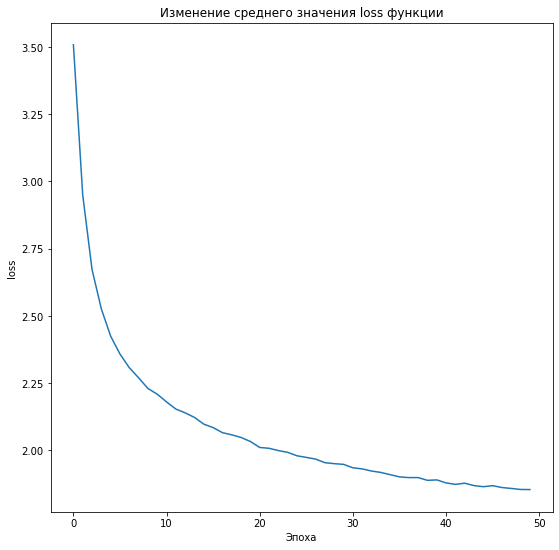

In [331]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(l_avg)
plt.show()

In [330]:
print(generate(net, device, text_dataset, 'In this research', 200, .2), '\n')

In this researchis proposed and the propose the proposed and the problem and the constrate a network of the set in the simplement and the proposed and the state the sension and the algorithm and the s 



In [ ]:
# вывод слоёв модели
layers = [module for module in net.modules()]
print(layers)

In [111]:
# collate_fn testing
# # input_size = 98 # torch.Size([2, 98, 100])
# # input_size = 2 # torch.Size([2, 98, 100])
# # input_size = 1 # ошибка

# btc = collate_fn(arxiv_dataset["summary"][:2]) # берём батч размера batch_size=2

# input_size = 98 # == число уникальных символов в датасете
# hidden_size = 100
# batch_size = 2
# encoderrrr = nn.Embedding(input_size, hidden_size)
# linearrrr = nn.Linear(input_size, hidden_size)
# for chars in range(1): # для примера, берём только одну, первую букву
#     inputs = btc['inputs'][:,chars].cpu()
#     print("inputs:", inputs) # 
#     print("inputs shape:", inputs.shape)
    
#     print("================embedding==================")
# #     print("inputs[0]:\n", inputs[0])
# #     print("inputs.view(batch_size, -1):\n", inputs.view(batch_size, -1))
#     encoded = encoderrrr(inputs.view(batch_size,-1)) # преобразовывается каждый элемент one-hot вектора в вектор hidden для всех батчей (2x98-->2x98x100)
# #     encoded = encoderrrr(inputs)
#     print("inputs after encoder:", encoded)
#     print("inputs shape after encoder:", encoded.shape)
    
#     print("================summ==================")
#     summed = torch.zeros(len(inputs), 100)
#     for mini_batch in range(len(inputs)):
# #         encoded[mini_batch] = encoded[mini_batch].sum(0)
# #         print("inputs after encoder sum:", encoded[mini_batch].sum(0))
#         summed[mini_batch] = encoded[mini_batch].sum(0)
#     print("inputs after encoder sum:", summed)
#     print("inputs shape after encoder sum:", summed.shape)
    
#     print("================linear:==================")
#     lineared = linearrrr(inputs.float()) # преобразовываем one-hot вектор в вектор hidden для всех батчей (2x98-->2x100)
#     print("inputs after linear:", lineared)
#     print("inputs shapes after linear:",lineared.shape)

inputs: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], dtype=torch.int32)
inputs shape: torch.Size([2, 98])
================embedding==================
inputs after encoder: tensor([[[ 0.4356, -0.9803, -1.2567,  ...,  0.1187, -0.9767, -0.4646],
         [ 0.4356, -0.9803, -1.2567,  ...,  0.1187, -0.9767, -0.4646],
         [ 0.4356, -0.9803, -1.2567,  ...,  0.1187

In [148]:
# tensor testing
# test = torch.zeros(3, 5) # массив вложенности 2?
# test[0][0]=5
# test[1][1]=5
# test[1][2]=7
# print(test "\n", test[:,2])

tensor([[5., 0., 0., 0., 0.],
        [0., 5., 7., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [215]:
# # btc["inputs"][0][0] # первая строка первого мини-батча
# # btc["inputs"][1][0] # первая строка второго мини-батча
# print(btc["inputs"][0][0], "\n",btc["inputs"][1][0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.int32) 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.int32)


### Сохранение посчитанных данных

In [328]:
# # with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)
# # with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'wb') as f: # сохранение в бинарном формате
with open(r'losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)
with open(r'hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [16]:
# with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_avg.pkl', 'rb') as f:
    losses_avg = pickle.load(f)
# with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_best.pkl', 'rb') as f:
    losses_best = pickle.load(f)
losses_best = [i.tolist() for i in losses_best]
# with open(r'/content/drive/MyDrive/Универ/hidden.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'hidden.pkl', 'rb') as f:
    hidden = pickle.load(f)

In [458]:
# net.net_version = "GRU"
RNN.save_model(net_cpu, f'models/GRU_epoch_50_batch_1.ckpt')

In [459]:
device_cpu=torch.device("cpu")
# net_cpu = RNN.load_model("models/GRU_epoch_50_batch_1.ckpt").to(device_cpu)
net_cpu = RNN.load_model("models/GRU_epoch_50_batch_1.ckpt").to(device_cpu)
text_dataset_cpu = TextDataset("aboba", symbols, chunk_len=10, device=device_cpu)

In [422]:
torch.save(net_cpu, "models/GRU_epoch_50_batch_1.pb")
# model = torch.load("models/GRU_epoch_50_batch_1.pb")

In [460]:
print(generate(net_cpu, device_cpu, text_dataset_cpu, 'In this research', 200, .8), '\n')

In this researche explains, explores a sets recording through
a simple and the fewer quality sedge method to a correct validate interest
of lin a region. The obtain
furthermore, the recommonsidence in 



### Вывод графиков loss

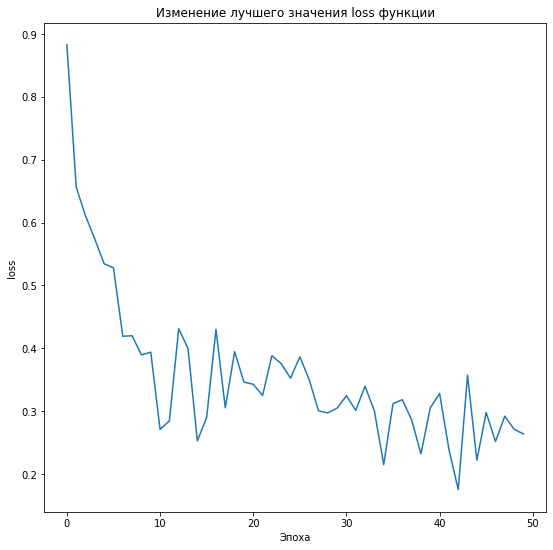

In [310]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(l_best)
plt.show()

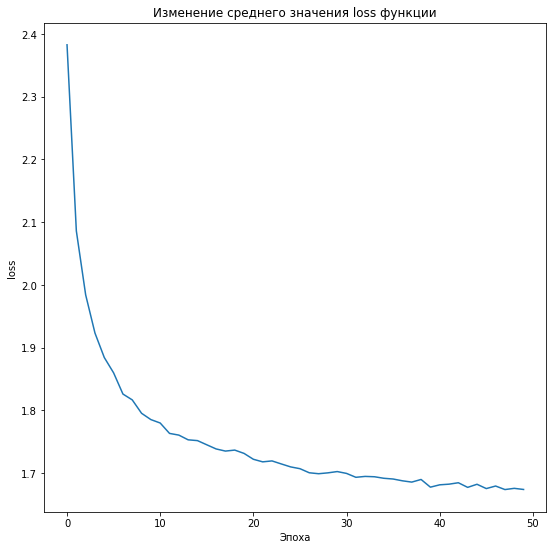

In [311]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(l_avg)
plt.show()

Выведем лучшие значения loss функции, а также эпоху, на которой они были достигнуты.

In [67]:
print("Лучшее значение loss:", min(losses_best),"получено на эпохе:", losses_best.index(min(losses_best)))
print("Лучшее среднее значение loss:", min(losses_avg),"получено на эпохе:", losses_avg.index(min(losses_avg)))

Лучшее значение loss: 0.02929740585386753 получено на эпохе: 33
Лучшее среднее значение loss: 2.5432336 получено на эпохе: 27


Как видно по графикам, обучение дольше 35-ти эпох не принесло особых улучшений, так как средний и лучший (по эпохе) loss остался примерно на том же уровне.

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)